## Previsão Ibovespa
Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

### 1. Entendimento do Negócio
O problema
Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%)

### 2. Entendimento dos Dados
Para isso, utilize a base de dados contida no site da Investing https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Testaremos alguns períodos Históricos para treinamento com uso de 180 dias anteriores para previsão.

In [1]:
!pip install requests beautifulsoup4 pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [41]:
# web scraping
url = "https://br.investing.com/indices/bovespa-historical-data"
response = requests.get(url)

In [42]:
# transforma o conteúdo HTML de uma página da web em um objeto Python
soup = BeautifulSoup(response.content, 'html.parser')

In [43]:
# Encontrar a tabela na página HTML
#table = soup.find('table', {'class': 'genTbl closedTbl historicalTbl'})
table = soup.find('table')

In [85]:
# Encontrar os cabeçalhos
headers = [th.text for th in table.find_all('th')]

In [45]:
# Encontrar os dados
data = []
for row in table.find_all('tr'):
    cols = row.find_all('td')
    data.append([col.text for col in cols])

In [46]:
# Imprimir os resultados
print("Cabeçalhos:", headers)
print("Dados Atuais:")
for row in data:
    print(row)

Cabeçalhos: ['', '', '', '', '', '', '']
Dados Atuais:
[]
['10.01.2025', '118.856', '119.781', '120.052', '118.732', '9,26M', '-0.77%']
['10.01.2025', '118.856', '119.781', '120.052', '118.732', '9,26M', '-0.77%']
['09.01.2025', '119.781', '119.625', '120.145', '119.502', '6,61M', '+0.13%']
['09.01.2025', '119.781', '119.625', '120.145', '119.502', '6,61M', '+0.13%']
['08.01.2025', '119.625', '121.160', '121.160', '119.351', '10,23M', '-1.27%']
['08.01.2025', '119.625', '121.160', '121.160', '119.351', '10,23M', '-1.27%']
['07.01.2025', '121.163', '120.022', '121.713', '120.022', '11,12M', '+0.95%']
['07.01.2025', '121.163', '120.022', '121.713', '120.022', '11,12M', '+0.95%']
['06.01.2025', '120.022', '118.534', '120.322', '118.534', '9,69M', '+1.26%']
['06.01.2025', '120.022', '118.534', '120.322', '118.534', '9,69M', '+1.26%']
['03.01.2025', '118.533', '120.125', '120.356', '118.404', '9,80M', '-1.33%']
['03.01.2025', '118.533', '120.125', '120.356', '118.404', '9,80M', '-1.33%']
['

In [86]:
df = pd.DataFrame(data, columns=['Data','Último','Abertura','Máxima','Mínima','Vol.', 'Var%'])

In [87]:
df = df.drop(index=0)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      30 non-null     object
 1   Último    30 non-null     object
 2   Abertura  30 non-null     object
 3   Máxima    30 non-null     object
 4   Mínima    30 non-null     object
 5   Vol.      30 non-null     object
 6   Var%      30 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


In [50]:
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1,10.01.2025,118.856,119.781,120.052,118.732,"9,26M",-0.77%
2,10.01.2025,118.856,119.781,120.052,118.732,"9,26M",-0.77%
3,09.01.2025,119.781,119.625,120.145,119.502,"6,61M",+0.13%


In [88]:
# Convertendo os valores para float e substituindo o ponto por vírgula
df['Último'] = df['Último'].astype(float)
df['Abertura'] = df['Abertura'].astype(float)
df['Máxima'] = df['Máxima'].astype(float)
df['Mínima'] = df['Mínima'].astype(float)
df['Var%'] = df['Var%'].str.replace('.', ',')

In [56]:
df.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
1,10.01.2025,118.856,119.781,120.052,118.732,"9,26M","-0,77%"
2,10.01.2025,118.856,119.781,120.052,118.732,"9,26M","-0,77%"
3,09.01.2025,119.781,119.625,120.145,119.502,"6,61M","+0,13%"


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 1 to 30
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      30 non-null     object 
 1   Último    30 non-null     float64
 2   Abertura  30 non-null     float64
 3   Máxima    30 non-null     float64
 4   Mínima    30 non-null     float64
 5   Vol.      30 non-null     object 
 6   Var%      30 non-null     object 
dtypes: float64(4), object(3)
memory usage: 1.8+ KB


In [14]:
df.shape

(30, 7)

In [58]:
# Teste para ver como estão os dados no Excel
#df.to_excel('dados_ibovespa.xlsx', index=False)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [16]:
url = 'https://raw.githubusercontent.com/Data-Analitycs-Pos-Tech-Fiap/Ibovespa-prev/refs/heads/main/datasets/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%202000%20a%202025.csv'

dados_030125 = pd.read_csv(url, sep=',', encoding='utf-8')

dados_030125.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.01.2025,118.533,120.125,120.356,118.404,"9,80B","-1,33%"
1,02.01.2025,120.125,120.283,120.782,119.120,"9,37B","-0,13%"
2,30.12.2024,120.283,120.267,121.050,120.158,"8,90B","0,01%"


In [89]:
# compreendendo os tipos de dados e o shape da base
print(dados_030125.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', dados_030125.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (4954, 7)


In [59]:
# Concatenando os DataFrames verticalmente
df_concatenado = pd.concat([df, dados_030125], ignore_index=True)

print(df_concatenado)

            Data   Último  Abertura   Máxima   Mínima     Vol.    Var%
0     10.01.2025  118.856   119.781  120.052  118.732    9,26M  -0,77%
1     10.01.2025  118.856   119.781  120.052  118.732    9,26M  -0,77%
2     09.01.2025  119.781   119.625  120.145  119.502    6,61M  +0,13%
3     09.01.2025  119.781   119.625  120.145  119.502    6,61M  +0,13%
4     08.01.2025  119.625   121.160  121.160  119.351   10,23M  -1,27%
...          ...      ...       ...      ...      ...      ...     ...
4979  10.01.2005   24.292    24.747   24.825   24.086  126,23M  -1,84%
4980  07.01.2005   24.747    24.376   24.874   24.376  104,96M   1,56%
4981  06.01.2005   24.367    24.695   24.808   24.250  151,17M  -1,32%
4982  05.01.2005   24.692    24.859   25.001   24.523  127,42M  -0,63%
4983  04.01.2005   24.848    25.722   25.873   24.791  146,14M  -3,40%

[4984 rows x 7 columns]


In [90]:
# Verificando duplicidades na coluna 'Data'
duplicados = df_concatenado['Data'].duplicated()
print(duplicados)
# Contando o número de duplicatas
print(duplicados.sum())

0       False
1        True
2       False
3        True
4       False
        ...  
4979    False
4980    False
4981    False
4982    False
4983    False
Name: Data, Length: 4984, dtype: bool
25


In [61]:
# Removendo as linhas duplicadas e atribuindo o resultado a um novo DataFrame
df_sem_duplicadas = df_concatenado.drop_duplicates(subset='Data', keep='first')

In [62]:
df_sem_duplicadas.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.01.2025,118.856,119.781,120.052,118.732,"9,26M","-0,77%"
2,09.01.2025,119.781,119.625,120.145,119.502,"6,61M","+0,13%"
4,08.01.2025,119.625,121.160,121.160,119.351,"10,23M","-1,27%"


In [63]:
# Verificando duplicidades na coluna 'Data'
duplicados2 = df_sem_duplicadas['Data'].duplicated()
print(duplicados2)
# Contando o número de duplicatas
print(duplicados2.sum())

0       False
2       False
4       False
6       False
8       False
        ...  
4979    False
4980    False
4981    False
4982    False
4983    False
Name: Data, Length: 4959, dtype: bool
0


In [91]:
dados = df_sem_duplicadas

In [66]:
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.01.2025,118.856,119.781,120.052,118.732,"9,26M","-0,77%"
2,09.01.2025,119.781,119.625,120.145,119.502,"6,61M","+0,13%"
4,08.01.2025,119.625,121.160,121.160,119.351,"10,23M","-1,27%"
6,07.01.2025,121.163,120.022,121.713,120.022,"11,12M","+0,95%"
8,06.01.2025,120.022,118.534,120.322,118.534,"9,69M","+1,26%"


In [67]:
dados.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [68]:
# Teste para ver como estão os dados no Excel
#dados.to_excel('dados_ibovespa.xlsx', index=False)

In [71]:
#df['Var%'] = df['Mínima'].astype(float)
dados['Var%'] = dados['Var%'].str.replace('%', '')

<ipython-input-71-75bd05a71db1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Var%'] = dados['Var%'].str.replace('%', '')


In [72]:
dados.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.01.2025,118.856,119.781,120.052,118.732,"9,26M","-0,77"
2,09.01.2025,119.781,119.625,120.145,119.502,"6,61M","+0,13"
4,08.01.2025,119.625,121.160,121.160,119.351,"10,23M","-1,27"


In [76]:
dados['Var%'] = dados['Var%'].str.replace(',', '.').astype(float)

AttributeError: Can only use .str accessor with string values!

In [93]:
dados.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-01-10,118.856,119.781,120.052,118.732,"9,26M",-0.77
2,2025-01-09,119.781,119.625,120.145,119.502,"6,61M",0.13
4,2025-01-08,119.625,121.160,121.160,119.351,"10,23M",-1.27


In [77]:
# Teste para ver como estão os dados no Excel
#dados.to_excel('dados_ibovespa.xlsx', index=False)

In [78]:
# Verificar valores ausentes
print(dados.isnull().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


In [79]:
# Tratar valores ausentes
dados.fillna(method='ffill', inplace=True)

<ipython-input-79-70ce5f8066d4>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados.fillna(method='ffill', inplace=True)
<ipython-input-79-70ce5f8066d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.fillna(method='ffill', inplace=True)


In [80]:
# Converter coluna de datas (se necessário)
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')

<ipython-input-80-91a0dfb5f86a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')


In [95]:
 #Converter a coluna 'Data' para datetime
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y', errors='coerce')

# Definir 'Data' como índice e ordenar
dados = dados.set_index('Data').sort_index()

# Reindexar com frequência diária
dados = dados.asfreq('D', method='ffill')

# Preencher valores NaN nas outras colunas
for column in dados.columns:
    dados[column] = dados[column].fillna(method='ffill')

# Resetar o índice
dados.reset_index(inplace=True)

# Verificar o resultado
print(dados.head(10))

        Data  Último  Abertura  Máxima  Mínima     Vol.  Var%
0 2005-01-04  24.848    25.722  25.873  24.791  146,14M -3.40
1 2005-01-05  24.692    24.859  25.001  24.523  127,42M -0.63
2 2005-01-06  24.367    24.695  24.808  24.250  151,17M -1.32
3 2005-01-07  24.747    24.376  24.874  24.376  104,96M  1.56
4 2005-01-08  24.747    24.376  24.874  24.376  104,96M  1.56
5 2005-01-09  24.747    24.376  24.874  24.376  104,96M  1.56
6 2005-01-10  24.292    24.747  24.825  24.086  126,23M -1.84
7 2005-01-11  24.370    24.295  24.457  24.127  111,40M  0.32
8 2005-01-12  24.510    24.370  24.560  23.983  107,12M  0.57
9 2005-01-13  24.806    24.523  24.919  24.523   91,08M  1.21


<ipython-input-95-0667918b3bdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y', errors='coerce')
<ipython-input-95-0667918b3bdf>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados[column] = dados[column].fillna(method='ffill')


In [96]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7312 entries, 0 to 7311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      7312 non-null   datetime64[ns]
 1   Último    7312 non-null   float64       
 2   Abertura  7312 non-null   float64       
 3   Máxima    7312 non-null   float64       
 4   Mínima    7312 non-null   float64       
 5   Vol.      7312 non-null   object        
 6   Var%      7312 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 400.0+ KB


In [97]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'

In [98]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'# renomeando colunas
dados = dados.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
dados = dados[['ds', 'y', 'unique_id']]
dados.head(3)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa
1,2005-01-05,24.692,ibovespa
2,2005-01-06,24.367,ibovespa


In [99]:
# df1 com data como índice e valores só coluna y
df1 = dados[['ds', 'y']]
df1 = dados.set_index('ds')

In [100]:
dados.head(1)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa


In [101]:
sns.set_style('darkgrid')

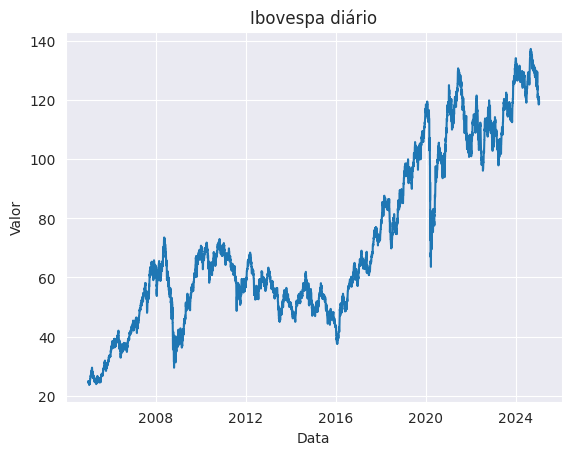

In [102]:
plt.plot(df1.index, df1["y"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

In [104]:
# Usada para decompor uma série temporal em suas componentes: tendência, sazonalidade e resíduos.
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
resultados = seasonal_decompose(df1['y'], model='additive', period=365)



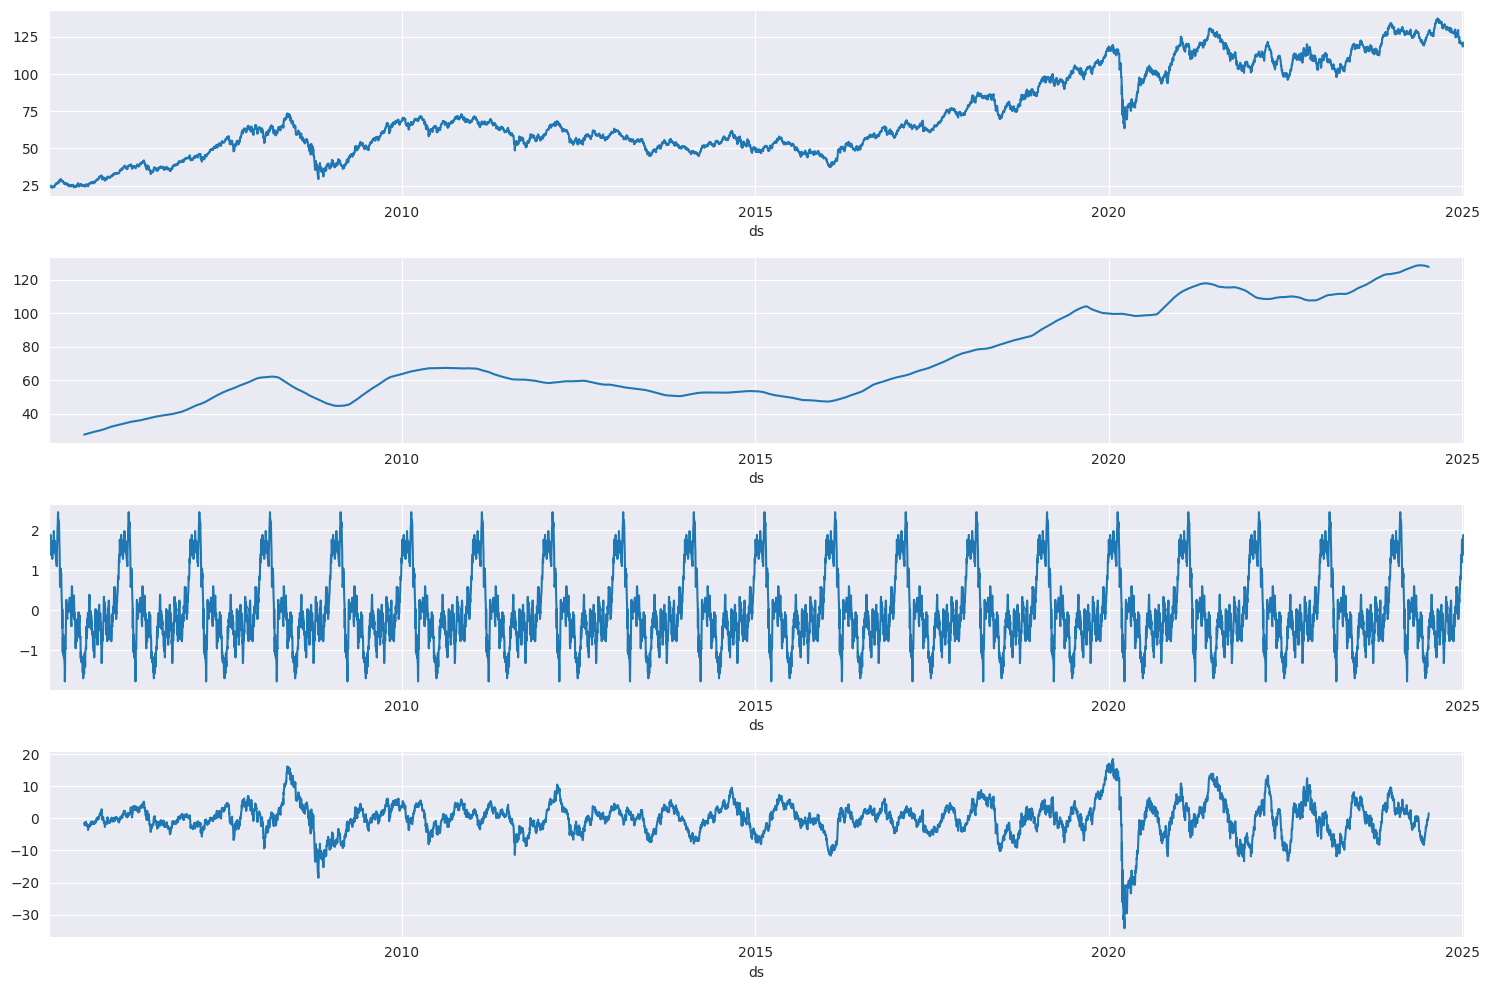

In [105]:
# Pela séria temporal original percebe-se que há uma média variável
# Possui uma Tendência

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame - série temporal original
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [106]:
# Verifica Estacionariedade
from statsmodels.tsa.stattools import adfuller

In [107]:
X = df1.y.values

In [109]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária
# Uma Série Não Estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.4488812063627807
P-Value: 0.5586307185391846
Valores críticos:
	1%: -3.4312466011794043
	5%: -2.8619362282168543
	10%: -2.5669809080325496


In [ ]:
df1.shape

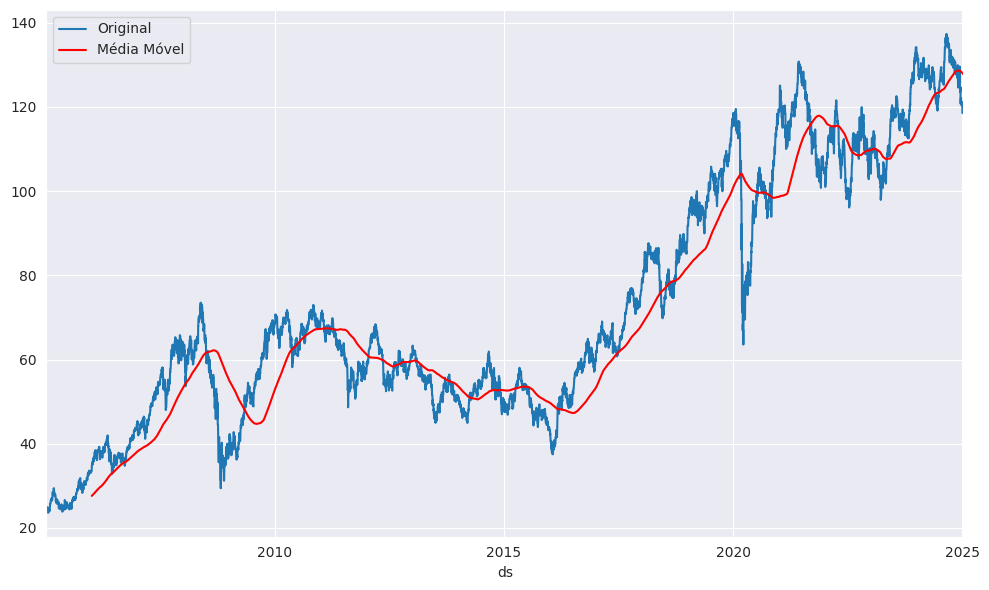

In [110]:
# Analisando a Tendência via a média

# Calcular média móvel com janela menor
ma = df1['y'].rolling(window=365).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df1['y'].plot(ax=ax, label='Original')
ma.plot(ax=ax, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()

In [111]:
df1 = df1.reset_index().rename(columns={'index': 'ds'})

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7312 entries, 2005-01-04 to 2025-01-10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          7312 non-null   float64
 1   unique_id  7312 non-null   object 
dtypes: float64(1), object(1)
memory usage: 171.4+ KB
None

Primeiras linhas do DataFrame:
                 y unique_id
ds                          
2005-01-04  24.848  ibovespa
2005-01-05  24.692  ibovespa
2005-01-06  24.367  ibovespa
2005-01-07  24.747  ibovespa
2005-01-08  24.747  ibovespa

Informações da média móvel:
ds
2005-01-04   NaN
2005-01-05   NaN
2005-01-06   NaN
2005-01-07   NaN
2005-01-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
364


In [116]:
df1=dados
df1

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa
1,2005-01-05,24.692,ibovespa
2,2005-01-06,24.367,ibovespa
3,2005-01-07,24.747,ibovespa
4,2005-01-08,24.747,ibovespa
...,...,...,...
7307,2025-01-06,120.022,ibovespa
7308,2025-01-07,121.163,ibovespa
7309,2025-01-08,119.625,ibovespa
7310,2025-01-09,119.781,ibovespa


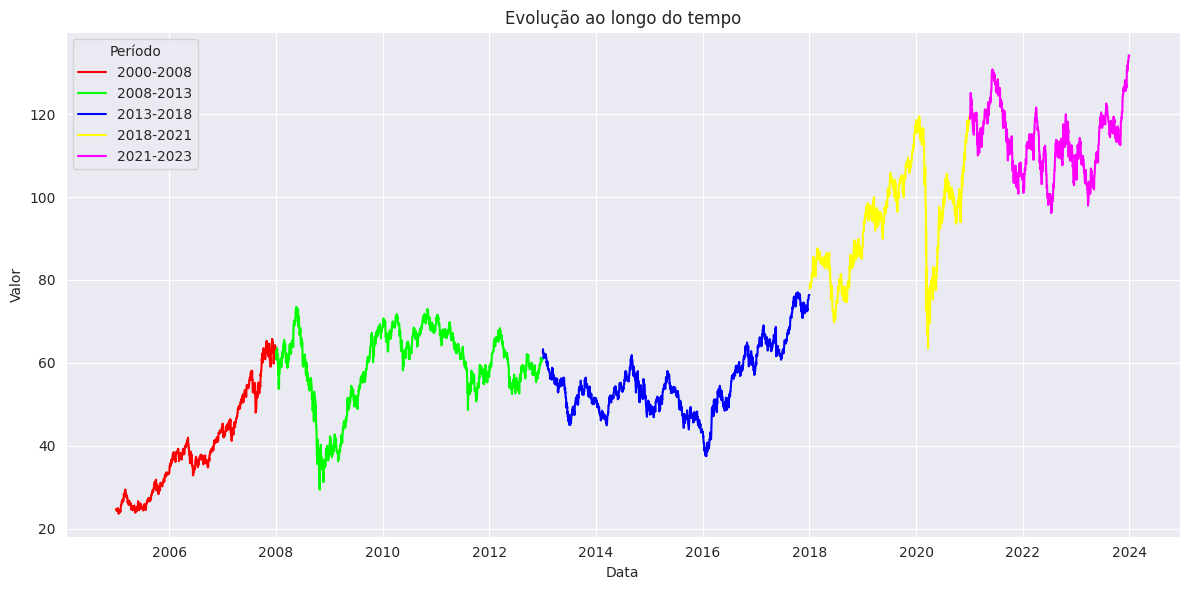

In [117]:
plt.figure(figsize=(12, 6))

# Definir as datas de corte
cut_dates = [
    datetime(2000, 1, 1),
    datetime(2008, 1, 1),
    datetime(2013, 1, 1),
    datetime(2018, 1, 1),
    datetime(2021, 1, 1),
    datetime(2023, 12, 31)
]

# Criar uma paleta de cores
colors = sns.color_palette(["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF"])

# Plotar cada linha
for i in range(len(cut_dates) - 1):
    mask = (df1['ds'] > cut_dates[i]) & (df1['ds'] <= cut_dates[i+1])
    sns.lineplot(
        data=df1[mask],
        x='ds',
        y='y',
        color=colors[i],
        label=f'{cut_dates[i].year}-{cut_dates[i+1].year}'
    )

# Configurar o gráfico
plt.title('Evolução ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend(title='Período')

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

In [118]:
def split_train_test(df, start_date, test_ratio=0.2):
    # Filtra o DataFrame para incluir apenas dados a partir da data de início especificada
    df_period = df[df['ds'] >= start_date]

    # Calcula o índice de corte com base na proporção de teste
    cutoff_index = int(len(df_period) * (1 - test_ratio))

    # Cria o conjunto de treino com dados até o índice de corte (exclusive)
    df_train = df_period.iloc[:cutoff_index]

    # Cria o conjunto de teste com dados a partir do índice de corte
    df_test = df_period.iloc[cutoff_index:]

    # Retorna os conjuntos de treino e teste
    return df_train, df_test

Na função split_train_test, a data de início especificada é o parâmetro start_date. Esta data não é fixa dentro da função, mas é passada como um argumento quando a função é chamada.

In [119]:
start_dates = [
    pd.Timestamp('2000-01-01'),  # Desde o início da série histórica
    pd.Timestamp('2008-01-01'),  # Últimos 15 anos
    pd.Timestamp('2013-01-01'),  # Últimos 10 anos
    pd.Timestamp('2018-01-01'),  # Últimos 5 anos
    pd.Timestamp('2021-01-01')   # Últimos 3 anos
]


In [120]:
#  cria uma lista de tuplas, onde cada tupla contém um conjunto de treinamento e um conjunto de teste
dfs = [split_train_test(df1, start_date) for start_date in start_dates]

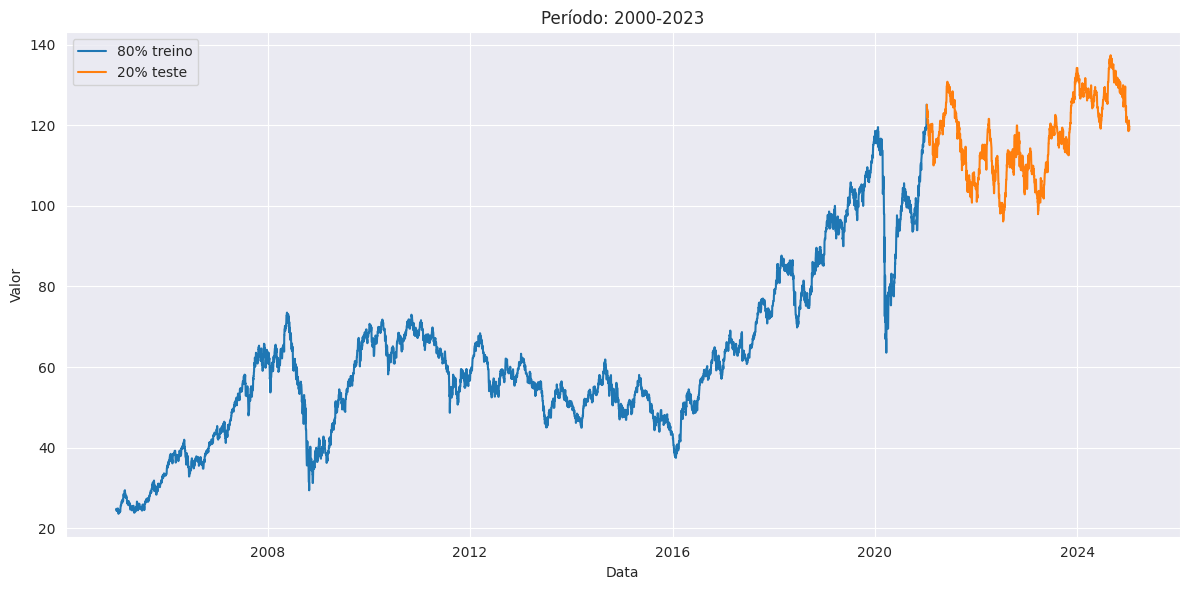

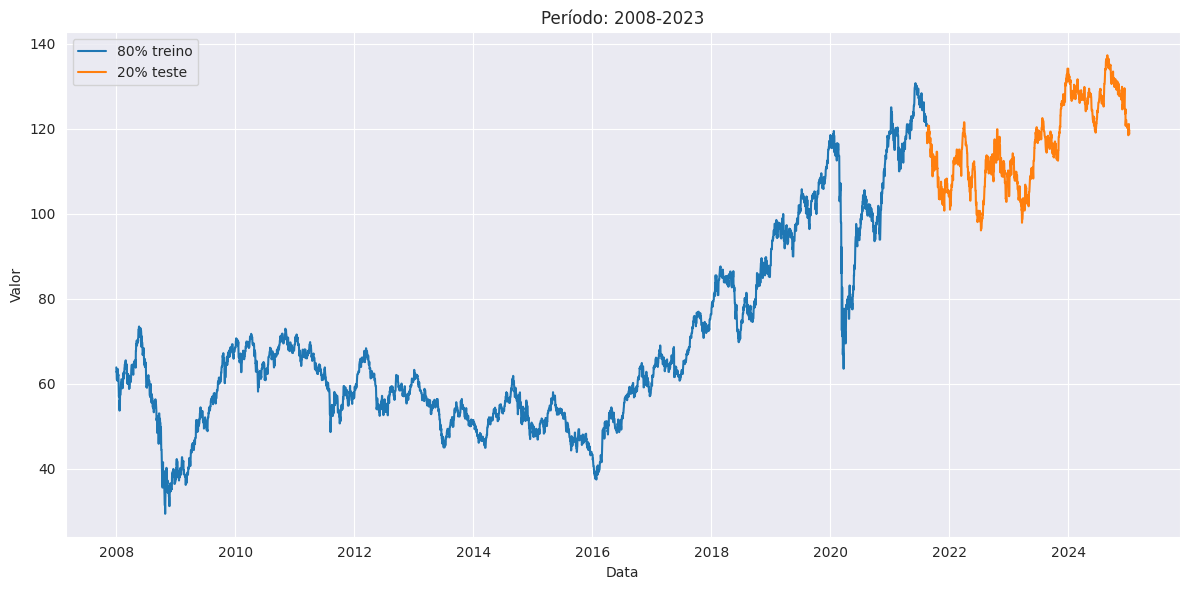

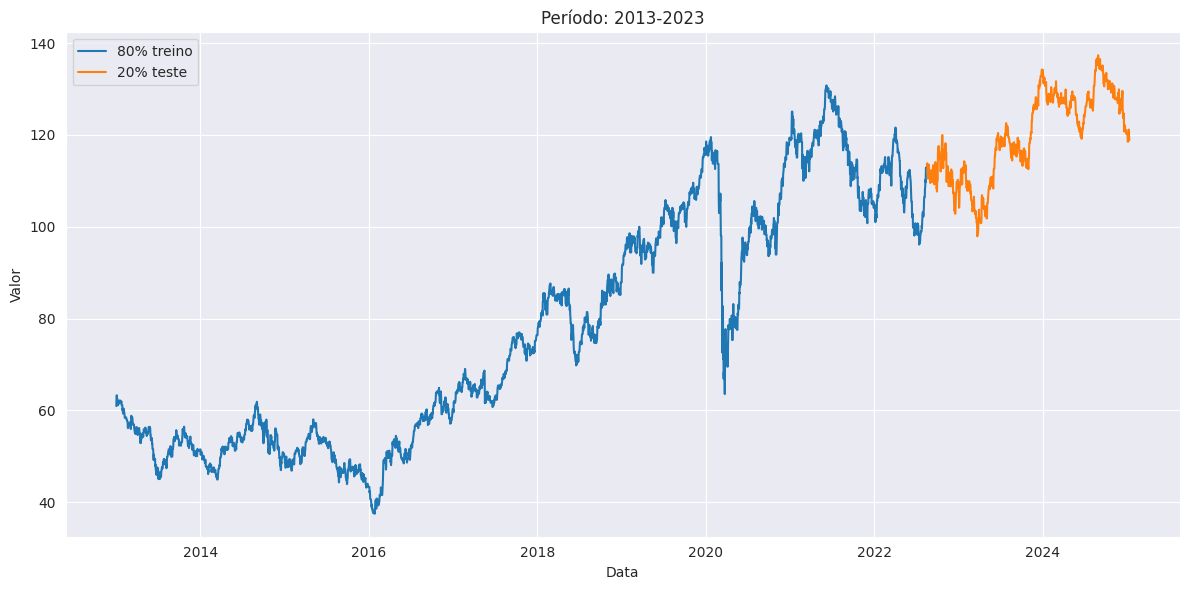

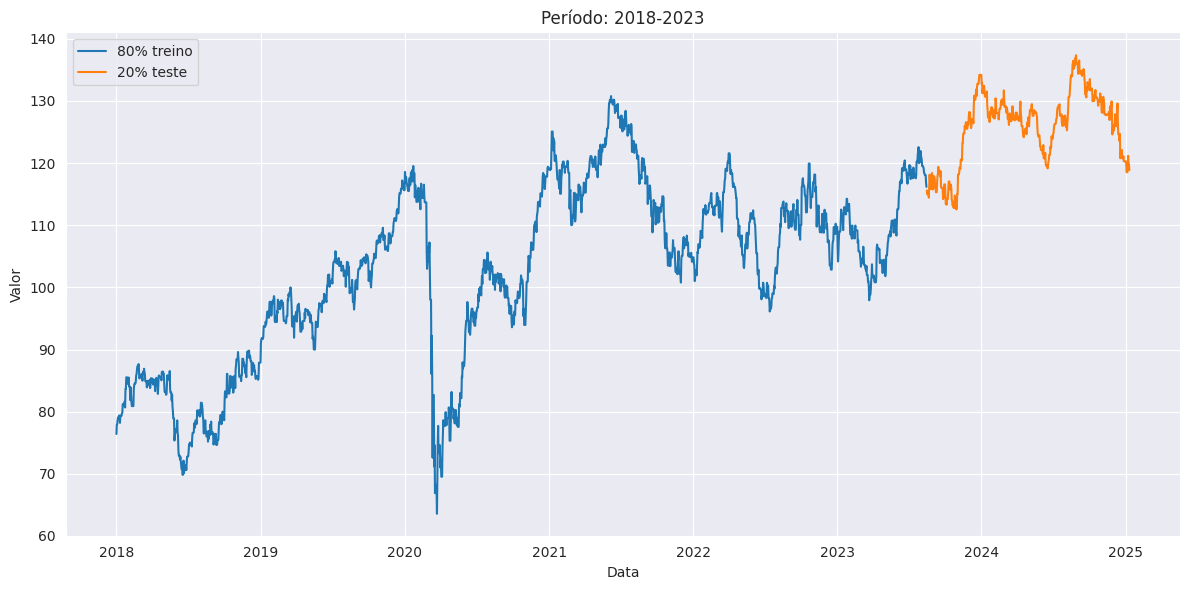

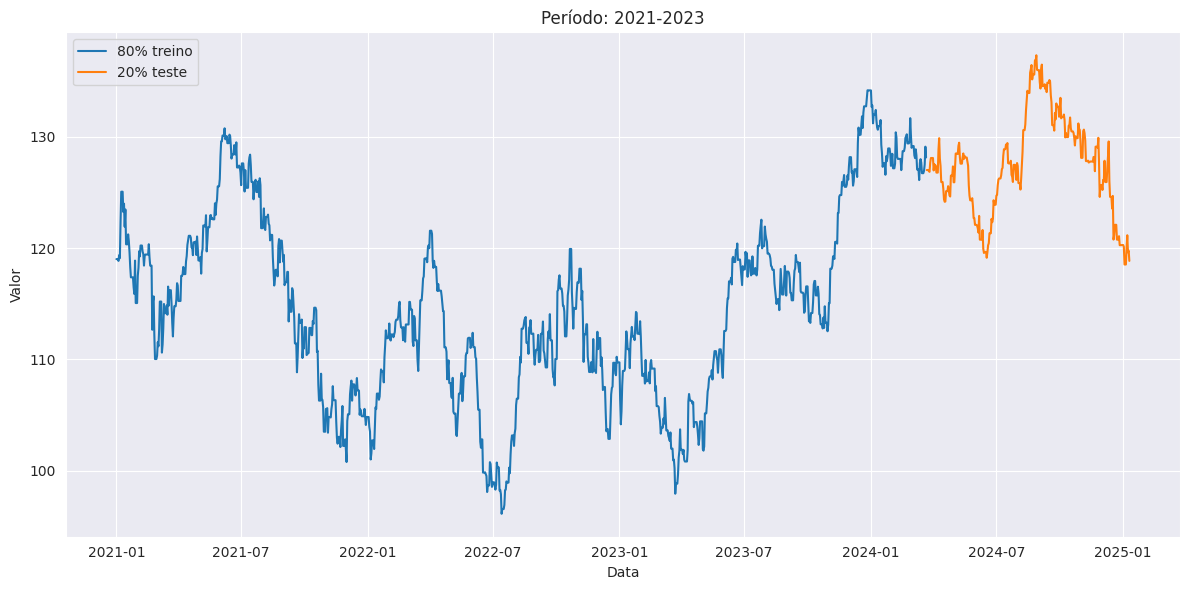

In [121]:
for i, (df_train, df_test) in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=df_train, x='ds', y='y', label='80% treino', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='20% teste', ax=ax)

    ax.set_title(f'Período: {start_dates[i].year}-2023')
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [122]:
# Verificar o DataFrame df1
print("Informações do DataFrame:")
print(df1.info())
print("\nPrimeiras linhas do DataFrame:")
print(df1.head())

# Verificar a série da média móvel
print("\nInformações da média móvel:")
print(ma.head())
print("\nVerificar valores nulos na média móvel:")
print(ma.isnull().sum())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7312 entries, 0 to 7311
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         7312 non-null   datetime64[ns]
 1   y          7312 non-null   float64       
 2   unique_id  7312 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 171.5+ KB
None

Primeiras linhas do DataFrame:
          ds       y unique_id
0 2005-01-04  24.848  ibovespa
1 2005-01-05  24.692  ibovespa
2 2005-01-06  24.367  ibovespa
3 2005-01-07  24.747  ibovespa
4 2005-01-08  24.747  ibovespa

Informações da média móvel:
ds
2005-01-04   NaN
2005-01-05   NaN
2005-01-06   NaN
2005-01-07   NaN
2005-01-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
364


In [125]:
# Lista dfs
dfs

[(             ds        y unique_id
  0    2005-01-04   24.848  ibovespa
  1    2005-01-05   24.692  ibovespa
  2    2005-01-06   24.367  ibovespa
  3    2005-01-07   24.747  ibovespa
  4    2005-01-08   24.747  ibovespa
  ...         ...      ...       ...
  5844 2021-01-04  118.855  ibovespa
  5845 2021-01-05  119.376  ibovespa
  5846 2021-01-06  119.100  ibovespa
  5847 2021-01-07  122.386  ibovespa
  5848 2021-01-08  125.077  ibovespa
  
  [5849 rows x 3 columns],
               ds        y unique_id
  5849 2021-01-09  125.077  ibovespa
  5850 2021-01-10  125.077  ibovespa
  5851 2021-01-11  123.255  ibovespa
  5852 2021-01-12  123.998  ibovespa
  5853 2021-01-13  121.933  ibovespa
  ...         ...      ...       ...
  7307 2025-01-06  120.022  ibovespa
  7308 2025-01-07  121.163  ibovespa
  7309 2025-01-08  119.625  ibovespa
  7310 2025-01-09  119.781  ibovespa
  7311 2025-01-10  118.856  ibovespa
  
  [1463 rows x 3 columns]),
 (             ds        y unique_id
  1092 2008-01

### Aplicando o logaritmo natural para os valores do df1, ajudando a estabilizar a variância e identificar as tendências

In [126]:
print(df1.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


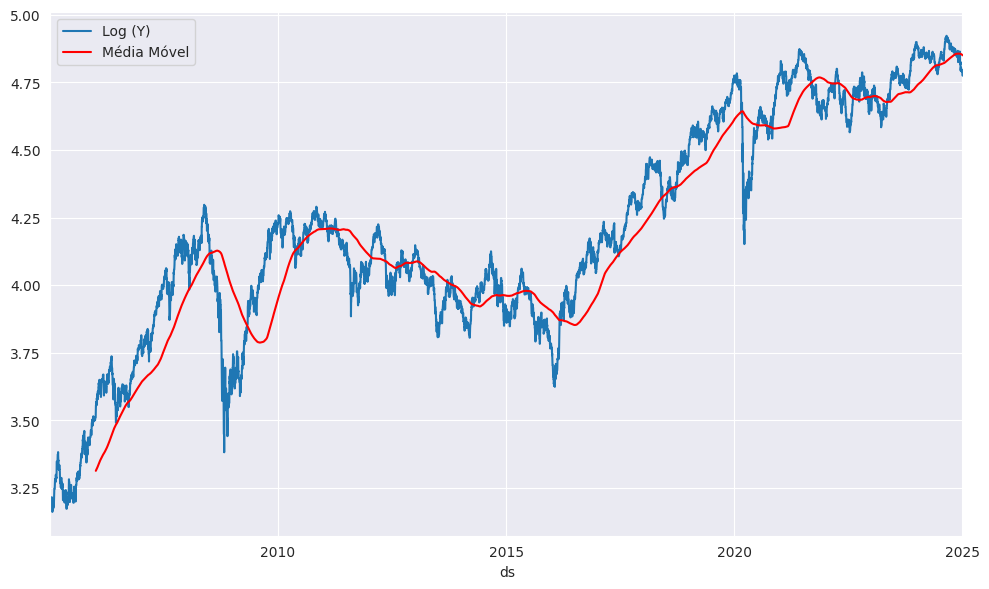

In [128]:
#selecionando somente as colunas ds e y, pois não são objetos
df_select = df1[['ds', 'y']]
# aplica a função logaritmo na coluna y
df_select['y_log'] = np.log(df_select['y'])
#calcular a media móvel
df_select['ma_log'] = df_select['y_log'].rolling(window=365).mean()

# Plotar o gráfico
f, ax = plt.subplots(figsize=(10,6))
# série logarítmica
df_select.plot(x ='ds', y='y_log',ax=ax, legend=False, label='Log (Y)')
df_select.plot(x='ds', y='ma_log', ax=ax, color='r', legend=False, label='Média Móvel')  # Média móvel
# Ajustar layout e adicionar legenda
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
serie_teste = df_select['y_log'].dropna()
resultado = adfuller(serie_teste)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária
# p-value é maior que 5%

print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print("Valores críticos:")

for key, value in resultado[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.157358250940284
P-Value: 0.22208416715207185
Valores críticos:
	1%: -3.4312482021580375
	5%: -2.861936935618387
	10%: -2.5669812845932594


In [130]:
print(df_select.dtypes)
print(df_select.head(5))

ds        datetime64[ns]
y                float64
y_log            float64
ma_log           float64
dtype: object
          ds       y     y_log  ma_log
0 2005-01-04  24.848  3.212777     NaN
1 2005-01-05  24.692  3.206479     NaN
2 2005-01-06  24.367  3.193230     NaN
3 2005-01-07  24.747  3.208704     NaN
4 2005-01-08  24.747  3.208704     NaN


Análise dos Resultados do Teste ADF (Dickey-Fuller)
Os resultados apresentados indicam que a série y_log foi testada para estacionariedade, e os valores obtidos foram:

Estatística ADF: -2.1616

A estatística ADF não está significativamente abaixo dos valores críticos fornecidos.
P-Valor: 0.2204

O p-valor é maior que 0.05, o que significa que não podemos rejeitar a hipótese nula (H₀). A hipótese nula assume que a série não é estacionária.
Valores Críticos:

Para níveis de significância de 1%, 5% e 10%, os valores críticos são: -3.4312, -2.8619, e -2.5669. A estatística ADF não está abaixo de nenhum deles.

Conclusão
Os resultados indicam que a série não é estacionária. Isso significa que o modelo ARIMA, ou outro baseado em séries temporais, terá dificuldades em capturar padrões adequados sem primeiro tornar a série estacionária.

**Transformar a série em estácionária.**

In [132]:
# Aplicar diferenciação na série log-transformada
df_select['y_log_diff'] = df_select['y_log'].diff().dropna()

# Repetir o teste ADF para a série diferenciada
serie_teste_diff = df_select['y_log_diff'].dropna()
resultado_diff = adfuller(serie_teste_diff)

print("Teste ADF para Série Diferenciada:")
print(f"Estatística ADF: {resultado_diff[0]}")
print(f"P-Valor: {resultado_diff[1]}")
print("Valores Críticos:")
for key, value in resultado_diff[4].items():
    print(f"  {key}: {value}")


Teste ADF para Série Diferenciada:
Estatística ADF: -15.537302183418932
P-Valor: 2.181818093269132e-28
Valores Críticos:
  1%: -3.4312482021580375
  5%: -2.861936935618387
  10%: -2.5669812845932594
